In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

%matplotlib inline

In [2]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=5
)

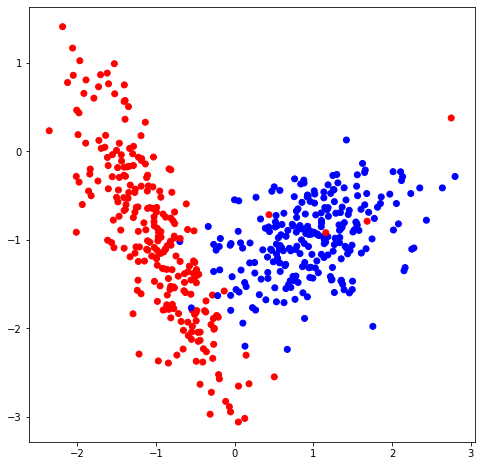

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

In [4]:
class Node:
    """Decision tree Node elelent."""
    
    def __init__(self, index, t, true_branch, false_branch):
        """Constructor."""
        
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [5]:
class Leaf:
    """Decision tree terminal Node element."""
    
    def __init__(self, data, labels):
        """Constructor."""
        
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        """Number of classes objects count."""
        
        classes = {}
        
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
                
            classes[label] += 1
            
        prediction = max(classes,
                         key=classes.get)
        
        return prediction

In [6]:
def gini(labels):
    """Gini impurity criterion evaluation."""
    
    classes = {}
    
    for label in labels:
        if label not in classes:
            classes[label] = 0
        
        classes[label] += 1
        
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
def quality(left_labels, right_labels, current_gini):
    """Quality evaluation."""
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
def split(data, labels, index, t):
    """Node split dataset."""
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [9]:
def find_best_split(data, labels):
    """Best split search."""
    
    min_leaf = 5
    
    current_gini = gini(labels)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
                
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
    return best_quality, best_t, best_index

In [10]:
def build_tree(data, labels):
    """Recursive tree building."""
    
    quality, t, index = find_best_split(data, labels)
    
    if quality == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):
    """Make classification."""
    
    if isinstance(node, Leaf):
        answer = node.prediction
        
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    """Make prediction."""
    
    classes = []
    
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
        
    return classes

In [13]:
def print_tree(node, spacing=''):
    """Print tree."""
    
    if isinstance(node, Leaf):
        print(spacing + 'Foreseen:', node.prediction)
        
        return
    
    print(spacing + 'Index', str(node.index))
    print(spacing + 'Treshold', str(node.t))
    
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + ' ')
    
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + ' ')

In [14]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

In [15]:
decision_tree = build_tree(train_data, train_labels)

In [16]:
print_tree(decision_tree)

Index 0
Treshold -0.051771417967220734
--> True:
 Index 0
 Treshold -0.36637542342372253
 --> True:
  Index 0
  Treshold -0.7126883788993976
  --> True:
   Foreseen: 0
  --> False:
   Index 1
   Treshold -1.3373577592210018
   --> True:
    Foreseen: 0
   --> False:
    Foreseen: 0
 --> False:
  Index 1
  Treshold -1.8741394984788107
  --> True:
   Foreseen: 0
  --> False:
   Foreseen: 1
--> False:
 Index 1
 Treshold -2.238294346478628
 --> True:
  Foreseen: 0
 --> False:
  Index 0
  Treshold 1.1573428257768366
  --> True:
   Foreseen: 1
  --> False:
   Index 0
   Treshold 1.1878872129209608
   --> True:
    Foreseen: 1
   --> False:
    Foreseen: 1


In [17]:
train_answers = predict(train_data, decision_tree)

In [18]:
answers = predict(test_data, decision_tree)

In [19]:
def accuracy_metric(actual, predicted):
    """Accuracy evaluation."""
    
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
            
    return correct / float(len(actual)) * 100.0

In [20]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(f'Точность на обучающей выборке: {train_accuracy}')
print(f'Точность на тестовой выборке: {test_accuracy}')

Точность на обучающей выборке: 98.85714285714286
Точность на тестовой выборке: 94.66666666666667


<ipython-input-21-b40a395a025e>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
<ipython-input-21-b40a395a025e>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=94.67')

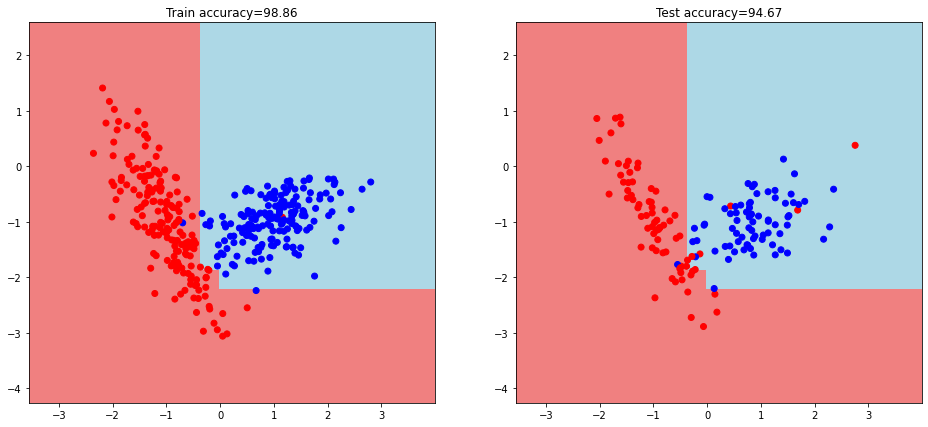

In [21]:
def get_meshgrid(data, step=.05, border=1.2):
    """Get meshgrid."""
    
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], decision_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [22]:
def build_tree_stop(data, labels):
    """Recursive tree building."""
    
    quality, t, index = find_best_split(data, labels)
    
    if quality == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    
    return Node(index, t, true_branch, false_branch)

### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [23]:
def entropy(labels):
    """Entropy criterion evaluation."""
    
    classes = {}
    
    for label in labels:
        if label not in classes:
            classes[label] = 0
        
        classes[label] += 1
        
    shennon = 0
    for label in classes:
        p = classes[label] / len(labels)
        shennon -= p * np.log2(p)
        
    return shennon

In [ ]:
def entropy_quality(left_labels, right_labels, current_gini):
    """Quality evaluation."""
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)